In [1]:

# For data loading
import anndata as ad
import scanpy as sc
import pytorch_lightning as pl
import torch

from wcd_vae.data import get_dataloader_from_adata
from wcd_vae.model import VAE, VAEConfig
from wcd_vae.metrics import compute_metrics

In [2]:
# download all the data
# from ladder.data import get_data
# get_data("Vu")
# get_data("Ji")
# get_data("Mascharak")

In [3]:
# set seeds
pl.seed_everything(42)

Seed set to 42


42

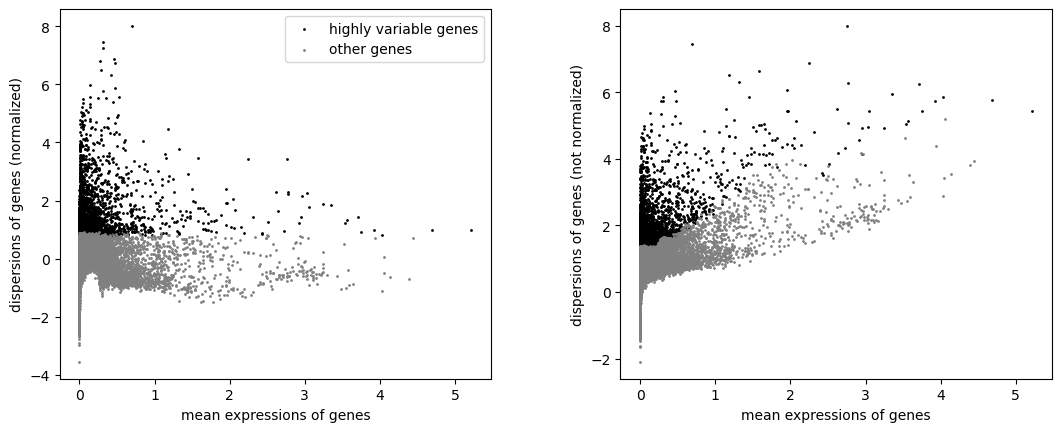

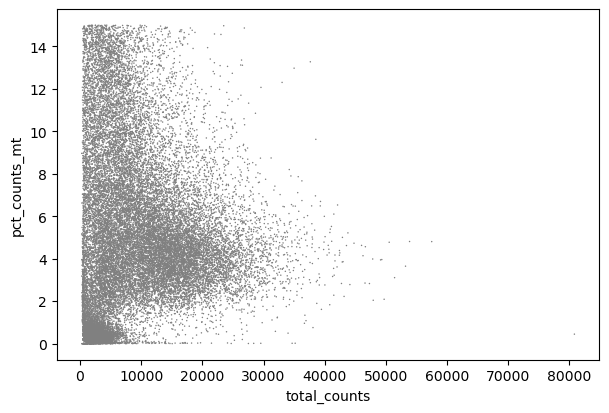

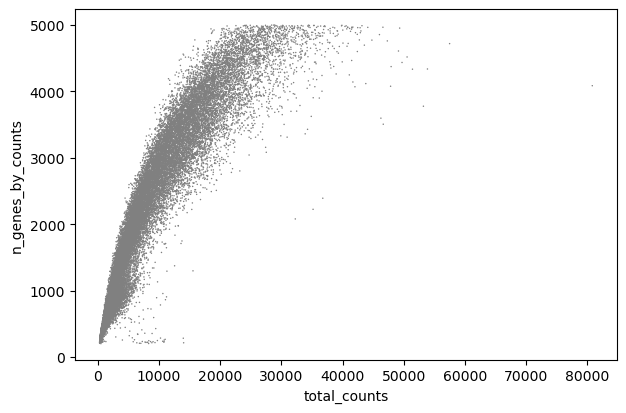

In [4]:
import scanpy as sc
import anndata as ad

# Load the data
anndata = ad.read_h5ad("data/vu_2022_ay_wh.h5ad")

# Save raw counts (if not saved yet)
if "counts" not in anndata.layers:
    anndata.layers["counts"] = anndata.X.copy()

# # Normalize total counts per cell
# sc.pp.normalize_total(anndata, target_sum=1e4)

# # Log-transform
# sc.pp.log1p(anndata)

# Find HVGs
sc.pp.highly_variable_genes(anndata, n_top_genes=3000, batch_key="sample")
sc.pl.highly_variable_genes(anndata)

# QC plots (optional)
sc.pl.scatter(anndata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(anndata, x="total_counts", y="n_genes_by_counts")

# Subset to HVGs, keep normalized + log data
anndata = anndata[:, anndata.var["highly_variable"]].copy()


In [5]:
import numpy as np

# Convert to dense float array if needed
X = anndata.X
if not isinstance(X, np.ndarray):
    X = X.A if hasattr(X, "A") else X.toarray()
X = X.astype(np.float64)

print("Checking for NaNs in anndata.X:", np.isnan(X).any())
print("Checking for infinite values in anndata.X:", np.isinf(X).any())
print("Max value in anndata.X:", np.max(X))
print("Min value in anndata.X:", np.min(X))

# If using layers (e.g., counts), check those too
if "counts" in anndata.layers:
    counts = anndata.layers["counts"]
    if not isinstance(counts, np.ndarray):
        counts = counts.A if hasattr(counts, "A") else counts.toarray()
    counts = counts.astype(np.float64)
    print("Checking for NaNs in anndata.layers['counts']:", np.isnan(counts).any())
    print("Checking for infinite values in anndata.layers['counts']:", np.isinf(counts).any())
    print("Max value in anndata.layers['counts']:", np.max(counts))
    print("Min value in anndata.layers['counts']:", np.min(counts))

Checking for NaNs in anndata.X: False
Checking for infinite values in anndata.X: False
Max value in anndata.X: 8.49746322631836
Min value in anndata.X: 0.0
Checking for NaNs in anndata.layers['counts']: False
Checking for infinite values in anndata.layers['counts']: False
Max value in anndata.layers['counts']: 20087.0
Min value in anndata.layers['counts']: 0.0


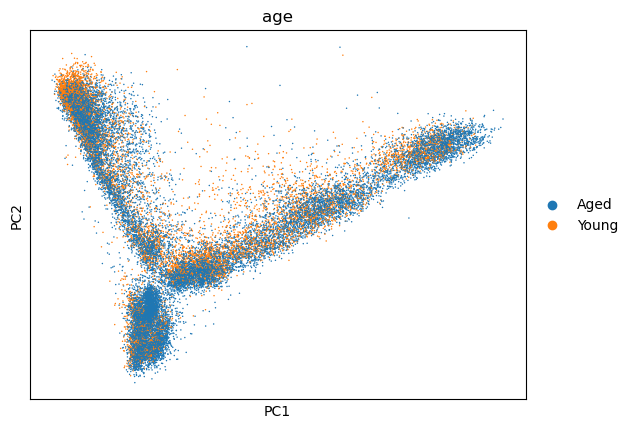

In [6]:
sc.pl.pca(anndata, color="age")

In [7]:
print(anndata.obs['age'].value_counts(normalize=True))

age
Aged     0.632129
Young    0.367871
Name: proportion, dtype: float64


In [8]:
print(anndata.obs['age'].value_counts(normalize=False))

age
Aged     17046
Young     9920
Name: count, dtype: int64


In [9]:
config = VAEConfig(
    input_dim=anndata.shape[1],
    latent_dim=32,
    encoder_hidden_dims=[128, 64],
    decoder_hidden_dims=[64, 128],
    dropout=0.2,
    batchsize=64,
    num_epochs=100,
    lr=1e-6,
    weight_decay=1e-5,
    kl_anneal_start=10,
    kl_anneal_end= 50,
    kl_anneal_max=1.0
)
vae = VAE(config)

In [10]:
train_loader, test_loader, domain_encoder, cell_encoder = get_dataloader_from_adata(anndata, by = 'age', batch_size=config.batchsize, num_workers=0)

In [11]:
trainer = pl.Trainer(
        max_epochs=config.num_epochs,
        accelerator="auto",  # use 'gpu' or 'cpu' explicitly if needed
        devices="auto",      # or use devices=1
        log_every_n_steps=10,
    )

trainer.fit(vae, train_dataloaders=train_loader, val_dataloaders=test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trad


  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 396 K  | train
1 | decoder | Decoder | 397 K  | train
--------------------------------------------
793 K     Trainable params
0         Non-trainable params
793 K     Total params
3.176     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 22.48it/s]

/opt/conda/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/opt/conda/envs/myenv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 99: 100%|██████████| 338/338 [00:13<00:00, 25.82it/s, v_num=53, train_loss_step=0.108, val_loss_step=0.124, val_recon_loss_step=0.123, val_kl_div_step=0.00133, val_loss_epoch=0.129, val_recon_loss_epoch=0.127, val_kl_div_epoch=0.00132, val/batch_entropy=0.693, val/ilisi_batch=2.000, val/clisi_celltype=1.220, val/silhouette_score=-0.0184, val/normalized_mutual_info=0.000413, train_loss_epoch=0.136] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 338/338 [00:13<00:00, 25.73it/s, v_num=53, train_loss_step=0.108, val_loss_step=0.124, val_recon_loss_step=0.123, val_kl_div_step=0.00133, val_loss_epoch=0.129, val_recon_loss_epoch=0.127, val_kl_div_epoch=0.00132, val/batch_entropy=0.693, val/ilisi_batch=2.000, val/clisi_celltype=1.220, val/silhouette_score=-0.0184, val/normalized_mutual_info=0.000413, train_loss_epoch=0.136]


Using log directory: lightning_logs/version_53


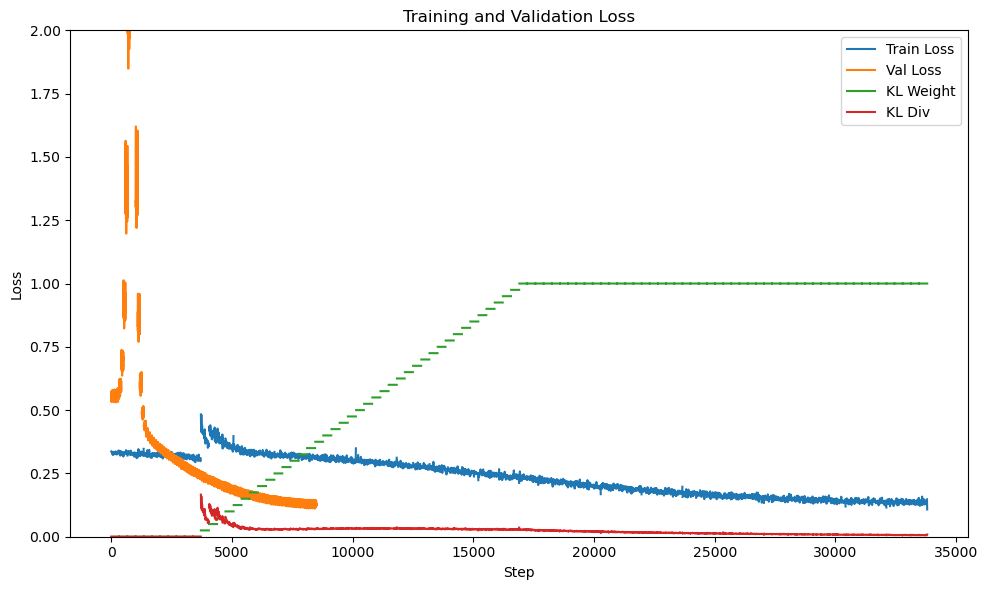

In [17]:
# plot the loss
import matplotlib.pyplot as plt
import pandas as pd

# Load the PyTorch Lightning logs (default: 'lightning_logs/version_x/metrics.csv')
import glob
import os

# get the latest log directory given by the largest number in version_x
log_dir = sorted(glob.glob('lightning_logs/version_*'), key=lambda x: int(x.split('_')[-1]))
if log_dir:
    log_dir = log_dir[-1]
else:
    log_dir = None

print("Using log directory:", log_dir)

metrics_path = os.path.join(log_dir, "metrics.csv")

# Read metrics
metrics = pd.read_csv(metrics_path)

# Remove rows with NaN values in loss columns
metrics = metrics.dropna(subset=["train_loss_step", "val_loss_step"], how="all")

plt.figure(figsize=(10, 6))
plt.plot(metrics["step"], metrics["train_loss_step"], label="Train Loss")
plt.plot(metrics["step"], metrics["val_loss_step"], label="Val Loss")
plt.plot(metrics["step"], metrics["kl_weight_step"], label="KL Weight")
plt.plot(metrics["step"], metrics["kl_div_step"] * metrics["kl_weight_step"], label="KL Div")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.ylim([0, 2])  # Adjust y-axis limits as needed
plt.title("Training and Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
metrics

,epoch,kl_div_epoch,kl_div_step,kl_weight_epoch,kl_weight_step,recon_loss_epoch,recon_loss_step,step,train_loss_epoch,train_loss_step,...,val/clisi_celltype,val/ilisi_batch,val/normalized_mutual_info,val/silhouette_score,val_kl_div_epoch,val_kl_div_step,val_loss_epoch,val_loss_step,val_recon_loss_epoch,val_recon_loss_step
0,0.0,NaN,0.262077,NaN,0.0,NaN,0.336745,9,NaN,0.336745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,0.253347,NaN,0.0,NaN,0.335360,19,NaN,0.335360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,0.259452,NaN,0.0,NaN,0.331858,29,NaN,0.331858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,NaN,0.266825,NaN,0.0,NaN,0.333020,39,NaN,0.333020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,0.257242,NaN,0.0,NaN,0.335613,49,NaN,0.335613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8495,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001333,NaN,0.132444,NaN,0.131111
12074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8496,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001392,NaN,0.127419,NaN,0.126027
12075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8497,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001202,NaN,0.121593,NaN,0.120391
12076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8498,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.001419,NaN,0.132646,NaN,0.131227


In [14]:
from tqdm import tqdm  # import tqdm

embeddings = []
batches = []
cell_type = []

vae.eval()
vae  = vae.to("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating VAE"):
        x, batch_label, cell_label = batch
        x, batch_label, cell_label = x.to(vae.device), batch_label.to(vae.device), cell_label.to(vae.device)
        recon_batch, embed, mu, logvar = vae(x)
        embeddings.append(embed.cpu())
        batches.append(batch_label.cpu())
        cell_type.append(cell_label.cpu())

# Concatenate the results
embeddings = torch.cat(embeddings, dim=0)
batches = torch.cat(batches, dim=0)
cell_type = torch.cat(cell_type, dim=0)


Evaluating VAE: 100%|██████████| 85/85 [00:00<00:00, 2778.79it/s]


In [15]:
compute_metrics(
    embeddings=embeddings,
    batch_labels=batches,
    cell_type_labels=cell_type,
)

{'batch_entropy': 0.6931471824645996,
 'ilisi_batch': 2.0,
 'clisi_celltype': 1.2195122241973877,
 'silhouette_score': -0.017438964918255806,
 'normalized_mutual_info': 0.00041299566030934126}

/opt/conda/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/myenv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


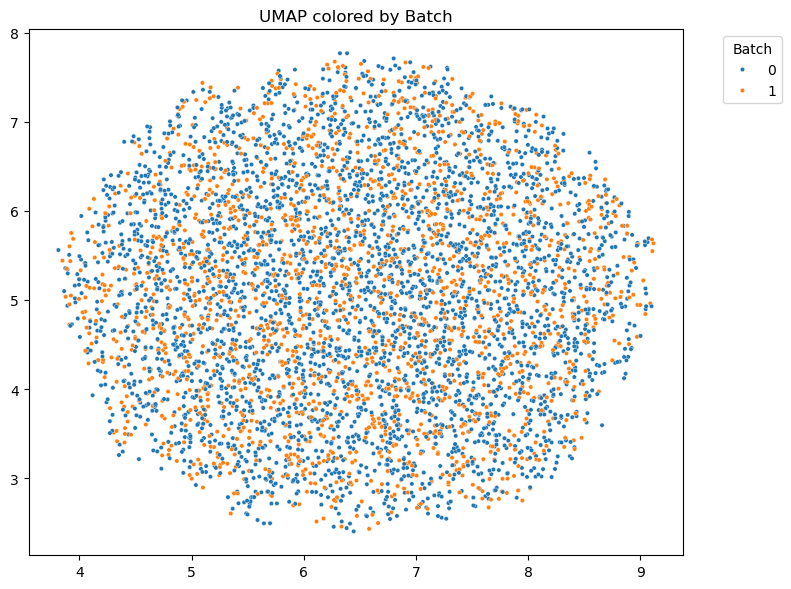

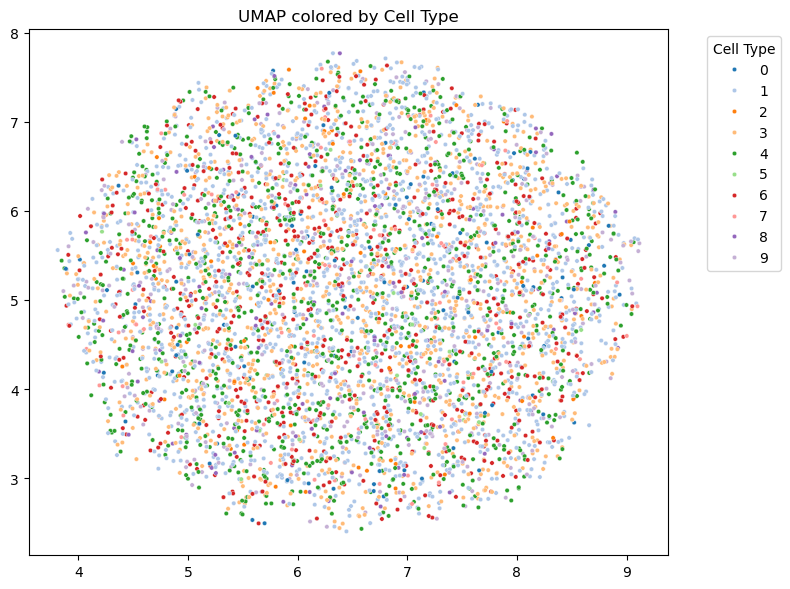

In [16]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Ensure embeddings, batches, and cell_type are on CPU and numpy
embeddings_np = embeddings.numpy()
batches_np = batches.argmax(dim=1).numpy()
cell_type_np = cell_type.argmax(dim=1).numpy()

# Fit UMAP on embeddings
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = umap_model.fit_transform(embeddings_np)

# Plot by batch
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=batches_np, palette="tab10", s=10)
plt.title("UMAP colored by Batch")
plt.legend(title="Batch", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Plot by cell type
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedding_2d[:, 0], y=embedding_2d[:, 1], hue=cell_type_np, palette="tab20", s=10)
plt.title("UMAP colored by Cell Type")
plt.legend(title="Cell Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
